# SEIR Generalize model with rho as an step function
#Author: Imelda Trejo 
#November: 25,2021

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import gamma
from scipy.stats import weibull_min
from scipy.stats import nbinom
from scipy.interpolate import BSpline
from matplotlib import cm
import datetime
from scipy.integrate import trapezoid

In [2]:
plt.rcParams.update({'font.size':16})
colors = cm.plasma(np.linspace(0,1,12))
dateIndex=np.load("dateIndex.npy",allow_pickle=True).ravel() #Incidence data
#print(dateIndex)

#Functions that does not depend on data

In [3]:
#---------Polynomial spline
def Pspline(t,vk,c,k,q0):
    n = len(vk) - k
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * BaseSpline(t, k, i, vk,q0) for i in range(n))   
#---------mixing-monotonic-and-standar-Base
def BaseSpline(t,k,i,T,q0): #k0,,t0=6--->90
    n = len(t)
    b=np.zeros(n) ##base function of degree k-1
    if i<=q0:
        aux=BSpline.basis_element(T[i+1:i+k+1],extrapolate=False) #degree k-2
        a=aux.integrate(T[i+1],T[i+k+1])
        for j in range(0,tp):                                 #M-spline degree k-1
            b[j]=1-aux.integrate(T[1],t[j])/a
    else:
        b= BSpline.basis_element(vk[i:i+k+1],extrapolate=False)(t) #degree k-1
    return np.nan_to_num(b)

#Reproductive Number, trapezoidal rule approx, constant projection
def RepNumber(Q,psi):
    tp=len(psi)
    A,Rt=np.zeros((tp-1,tp-1)),np.zeros(tp)
    for k in range(0,tp-1): #drop the last element 
        A[k,0:tp-k-1]=Q[k+1:tp]   
        A[k,tp-k-1:]=Q[tp-1]*np.ones(k)    
    Rt[0:tp-1]=h*(2*np.dot(A,psi[1:tp])+psi[0]*Q[0])/2
    Rt[tp-1]=Rt[tp-2] 
    return Rt

In [121]:
#---Muk----ls days constant period----
def MuK(rho): 
    mu,V,hatI=np.zeros(n+1),np.zeros(tp),np.zeros(m+1)
    V[0]=rho[0]*H[0,0]
    for k in range(1,n+1):
        for i in range(0,m+1):
            v=np.multiply(rho[m*(k-1):m*(k-1)+i],hatI[0:i])
            hatI[i]=h*(rho[m*(k-1)]*hatI[0]*psi[i]+2*np.dot(v[1:i],np.flip(psi[1:i])))/2+H[k-1,i] #hatI
        V[m*(k-1)+1:k*m+1]=np.multiply(rho[m*(k-1)+1:m*k+1],hatI[1:m+1]) #open-left
        mu[k]=h*(V[0]*W[k*m]+2*np.dot(V[1:m*k],np.flip(W[1:m*k]))+V[m*k]*W[0])/2    
    return mu+0.0001


In [15]:
#---Muk----ls days constant period----

def MuK(rho):
    mu = np.zeros(n+1)
    V = np.zeros(tp)
    hatI = np.zeros(m+1)
    V[0] = rho[0] * H[0, 0]

    for k in range(1, n+1):
        for i in range(0, m+1):
            hatI[i] = (h * (rho[m*(k-1)] * hatI[0] * psi[i] + 
                            2.0 * np.dot(rho[m*(k-1)+1 : m*(k-1)+i],
                                         np.flip(psi[1:i]))) )/ 2.0 + H[k-1, i]
        V[m*(k-1)+1 : k*m+1] = rho[m*(k-1)+1 : m*k+1] * hatI[1 : m+1]
        mu[k] = (h * (V[0] * W[k*m] + 2.0 * np.dot(V[1 : m*k], np.flip(W[1 : m*k])) + V[m*k] * W[0]) )/ 2.0
    
    return mu + 0.0001


# Ejemplo de uso:
# rho, H, psi, W, h, n, m, tp = ....  # tus datos aquí
# mu = MuK(rho, H, psi, W, h, n, m, tp)


In [142]:
#0,1,...,6,...,9
key=1
region = ['HIDALGO','PUEBLA','MICHOACAN','MEXICO', "AGUASCALIENTES","TABASCO","BAJA_CALIFORNIA_SUR", "QUINTANA_ROO"]
print(region[key])
##------------------------Read data------------

#Yaux=np.load("%s.npy"%region[key])  #Incidence data
Y=np.load("%s.npy"%region[key])  #Incidence data

#-----------------------Define the partition for the epidecmis time observed [0, T]  
n=np.size(Y)
print('observation days',n)

T,h,m=n,0.1,10
tp=int(T/h)+1            #total points
t=np.zeros(tp)
for i in range(0,tp):
    t[i]=h*i  

#--------------------Infectious period functions------#1-----------
Faux=np.load("F.npy")
Gaux=np.load("Gaux.npy") #1-G(t)
Psi=np.load("Psi.npy")
Aaux=np.load("A.npy")
Waux=np.load("W.npy")

#-----------------------redefine     
F=Faux[0:tp]
G=Gaux[0:tp]
psi=Psi[0:tp]  
A=Aaux[0:n,:]
W=Waux[0:tp]


PUEBLA
observation days 1021


In [143]:
#------------------------Base-spline interpolation----with partition (0,T)={0,xhi_1,...,xhi_q,T}
ls=21                    #length between the k-nots 
q=int(n/ls)+1         
vk=np.zeros(q)
for i in range(1,q-1):
    vk[i]=ls*i
vk[q-1]=n
#-------------------------------boundary-knots
vk=np.append([-3*ls,-2*ls,-ls],vk)
vk=np.append(vk,[n+ls,n+2*ls,n+3*ls])
#--------------Wigths
q=q+2  #base elements
print('Dimention of the Base-spline',q)    
#-------------------Bsplines functions: derivatives and gram matrix
q0=8                  #number of monotonic base functions
bd=np.zeros((q,tp-2)) ##array seconde derivatives of base function
Gr=np.zeros((q,q))    #Gram Matrix
print('monotonic properties till day:',vk[q0])
for i in range(0,q):
    bd[i,0:tp-2]=np.diff(BaseSpline(t,4,i,vk,q0),n=2)/(h*h)
for k in range(0,q):
    for j in range(0,q):
         Gr[k,j]=trapezoid(np.multiply(bd[k],bd[j]),t[0:tp-2])            

Dimention of the Base-spline 51
monotonic properties till day: 105.0


In [144]:
#---History-function---H----
H=np.zeros((n,m+1))
for k in range(1,n):
    for i in range(0,m+1):
            H[k,i]=np.dot(Y[0:k],np.flip(A[0:k,i])) + Y[0]*Gaux[k*i] #adding I0  

In [145]:
#---------------------------Epidemic Global Variables---------------------------

#----matrix auxiliar
B=np.zeros((m+1,m*(n-1)-1))
for k in range(2,n+1):
    for i in range(0,m+1): 
        B[i,0:m*(k-1)-1]=np.flip(psi[i+1:m*(k-1)+i])  
#-----------Wk-function-------------- 
W=np.zeros(tp)
for j in range(1,m+1):
    W[j]=F[j]
for j in range(m+1,tp):
    W[j]=F[j]-F[j-m]          
    


In [190]:
#to speead up the codes we use only tree sample point to build the credibles intervals.

parLog=np.genfromtxt(region[key]+'-parLog.txt')
#parLog=np.genfromtxt('round-2-'+region[key]+'-parLog.txt')

#print(len(parLog))
#sample_size=20000
#Par=parLog[len(parLog)-sample_size:len(parLog)] 

parLog=np.genfromtxt('round-2-'+region[key]+'-parLog.txt')

Par=parLog[15500:20000] 



print(len(Par))

P=Par[:,0:q]  #log(rho) coefitients 
R=Par[:,q]    #parameter
r=np.around(np.exp(np.median(R)),decimals=3)
print(r)

4500
4243.296


In [191]:
# to find uper and lower bounds
# THIS TAKE TOO MUCH TIME


# Initialize the array with zeros
#posterior_incidence = np.zeros((sample_size, n))

# Loop over samples
#for i in range(sample_size):
    # MuK should return a array-like structure
 #   v=np.exp(Pspline(t,vk,Par[i, 0:q],4,q0)) #rho(t)
 #   result = MuK(v)  
    #plt.plot(v)
  #  posterior_incidence[i,] = result[1:]  # Store starting from index 1


#y2,yL2,yU2=np.zeros(n),np.zeros(n),np.zeros(n)   #uper lower bounds
#for i in range(0,n):
 #   y2[i]=np.around(np.median(posterior_incidence[:,i]),decimals=5)
 #   yL2[i]=np.around(np.quantile(posterior_incidence[:,i],0.025),decimals=5)
 #   yU2[i]=np.around(np.quantile(posterior_incidence[:,i],0.975),decimals=5)  

In [192]:
#--------------------------Data set extraction

#-parameters for the repouctive rate function

PL,PR,PM=np.zeros(q),np.zeros(q),np.zeros(q)   #uper lower bounds
for i in range(0,q):
    PM[i]=np.around(np.median(P[:,i]),decimals=5)
    PL[i]=np.around(np.quantile(P[:,i],0.025),decimals=5)
    PR[i]=np.around(np.quantile(P[:,i],0.975),decimals=5)    
#posterior

rho=np.exp(Pspline(t,vk,PM,4,q0)) #log rho
rhoL=np.exp(Pspline(t,vk,PL,4,q0)) #log rho
rhoR=np.exp(Pspline(t,vk,PR,4,q0)) #log rho
RtR,Rt,RtL=RepNumber(rhoR,psi),RepNumber(rho,psi),RepNumber(rhoL,psi)


In [193]:
#Expected mean of incidence data

y1=MuK(rho)[1:]

yL1,yU1=np.zeros(n),np.zeros(n)
#
#----95%----Confidence Interval Level------
for k in range (0,n):
    if y1[k]!=0:
        pp=r/(r+y1[k])
        yL1[k]=nbinom.ppf(0.025, r,pp)
        yU1[k]=nbinom.ppf(0.975, r,pp)
         

In [194]:
#yL2=MuK(rhoL)[1:]
#yU2=MuK(rhoR)[1:]
TT=np.linspace(0,n,n)

#plt.plot(TT,yL2,"--",lw=3,color = 'k' )
#plt.plot(TT,yU2,"--",lw=3,color = 'k')

#plt.plot(TT,y1)
#plt.plot(TT,yL1)
#plt.plot(TT,yU1)


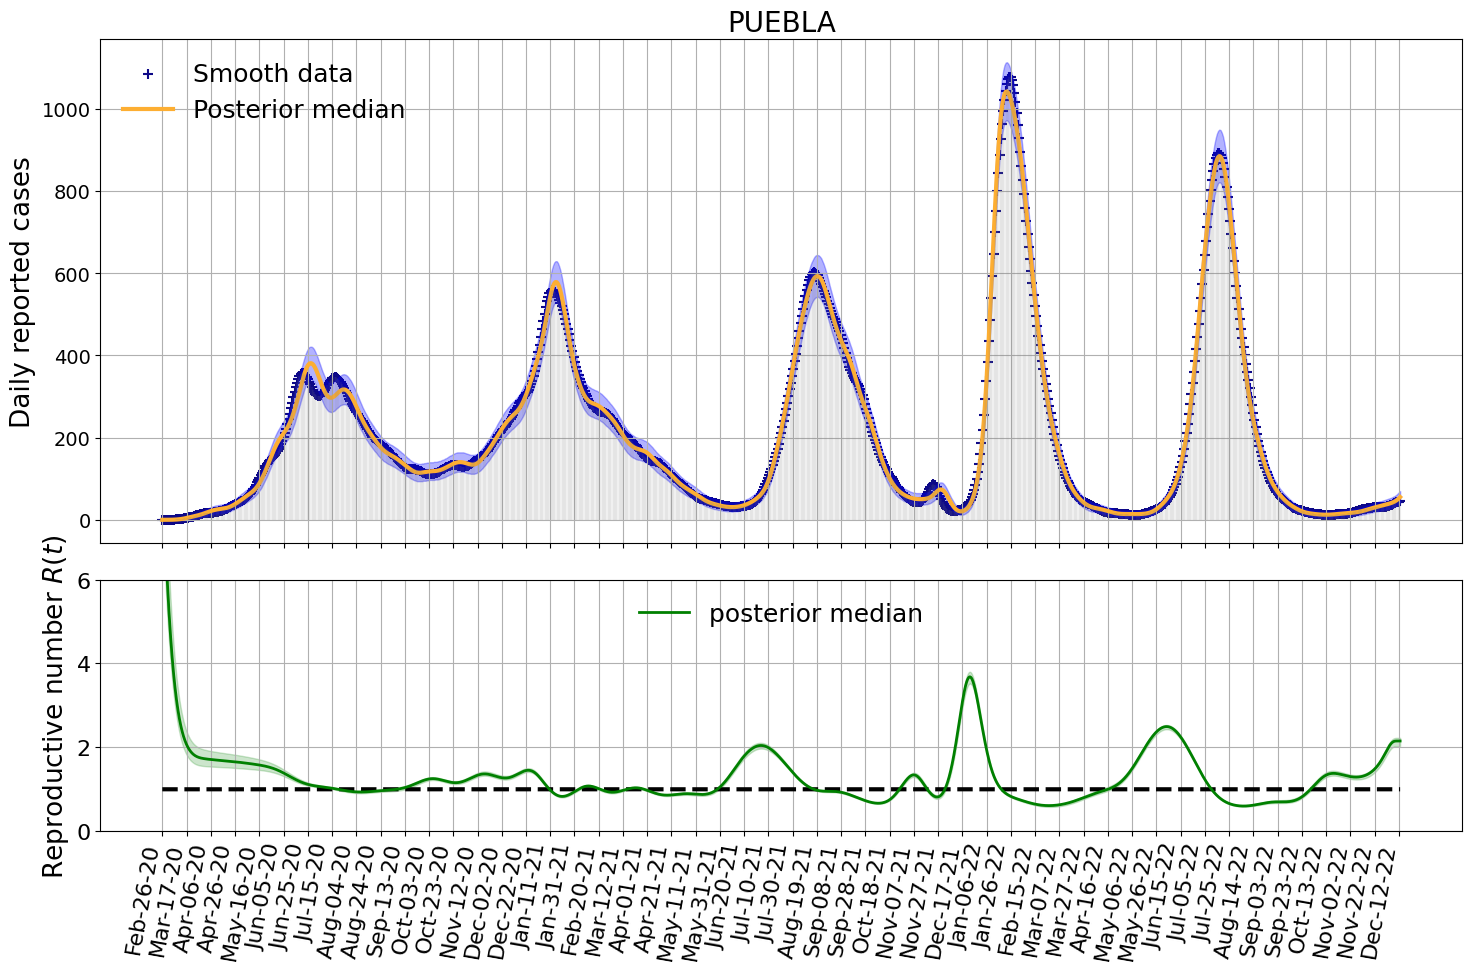

In [195]:

#Rt=1
R1=np.ones(tp)
fig, ax = plt.subplots(2,1,figsize=(15,10), gridspec_kw={'height_ratios': [2, 1]})

ax[0].scatter(TT,Y, 60, marker='+', color = colors[0], label='Smooth data')
ax[0].plot(TT,y1, color = colors[9],lw=3, label='Posterior median')
ax[0].fill_between(TT,yL1,yU1,color='b',alpha=.3)
#ax[0].fill_between(TT,yL1,yU1,color=colors[4],alpha=.3)

ax[0].vlines(TT,0,Y,color ='grey',alpha=.1)
#ax[0].scatter(TT[1:],Yaux, 20, marker='o', color = colors[0],alpha=.35, label='Raw data')

ax[0].set_ylabel('Daily reported cases',fontsize=19)
ax[0].set_title('%s' %region[key],fontsize=20)
ax[0].legend(loc='upper left',frameon=False,fontsize=18) 
ax[0].set_xticks(range(0,n,20))
ax[0].set_xticklabels(dateIndex[::20], rotation=45)

#ax[0].set_ylim(0,250)
ax[0].tick_params(labelsize=14)
ax[0].grid(axis='x')
ax[0].grid(axis='y')
fig.autofmt_xdate()

#
ax[1].plot(t,R1,'--',lw=3,color = 'k')
ax[1].fill_between(t,RtL,RtR,color ='g',alpha=.2)
ax[1].plot(t,Rt,color ='g',lw=2, label='posterior median',alpha=1)
#ax[1].fill_between(t,rhoL,rhoR,color ='b',alpha=.2)
#ax[1].plot(t,rho,color ='b',lw=2, label='posterior median',alpha=1)

#ax[1].axvline(x=init,color=colors[4],linestyle=':',linewidth=4,label='first reported cases')


ax[1].legend(loc=2, frameon=False)
ax[1].set_ylabel('Reproductive number $R(t)$',fontsize=19)
#ax[1].legend(loc='lower left') 
ax[1].legend(loc='upper center',frameon=False,fontsize=18) 

#ax[1].set_ylim(0,.8)
ax[1].set_ylim(0,6)
ax[1].grid(axis='x')
ax[1].grid(axis='y')
ax[1].set_xticks(range(0,n,20))
#plt.xlabel('Time (month-day-year)',fontsize=18)
plt.tick_params(labelsize=16)
ax[1].set_xticklabels(dateIndex[::20], rotation=80)
#fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('%s.pdf' % region[key])
